# 05wk-1: 깊은신경망 (4) – GPU 사용법, SGD, Softmax와 CrossEntropy

최규빈  
2024-04-01

<a href="https://colab.research.google.com/github/guebin/DL2024/blob/main/posts/05wk-1.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" style="text-align: left"></a>

# 1. 강의영상

<https://youtu.be/playlist?list=PLQqh36zP38-wjNGgd4gmQJbQ66NLjUC2y&si=dusDZAwGOJS9TOKJ>

# 2. Imports

In [2]:
import torch
import matplotlib.pyplot as plt
from fastai.data.all import *
import torchvision

# 3. CPU vs GPU

`-` 파이토치에서 GPU를 쓰는 방법을 알아보자. (사실 지금까지 우리는 CPU만
쓰고 있었음)

`-` 코랩에서 GPU설정하는 방법: (아래영상참고)

<https://youtu.be/GyBL2YBCzoc>

## A. GPU 사용방법

`-` cpu 연산이 가능한 메모리에 데이터 저장

In [3]:
torch.manual_seed(43052)
x_cpu = torch.tensor([0.0,0.1,0.2]).reshape(-1,1) 
y_cpu = torch.tensor([0.0,0.2,0.4]).reshape(-1,1) 
net_cpu = torch.nn.Linear(1,1) 

`-` gpu 연산이 가능한 메모리에 데이터 저장

In [4]:
!nvidia-smi # before

Mon Apr  1 16:42:53 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.161.07             Driver Version: 535.161.07   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3090        Off | 00000000:09:00.0 Off |                  N/A |
|  0%   35C    P8              34W / 420W |     26MiB / 24576MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [5]:
torch.manual_seed(43052)
x_gpu = x_cpu.to("cuda:0")
y_gpu = y_cpu.to("cuda:0")
net_gpu = torch.nn.Linear(1,1).to("cuda:0") 

In [6]:
!nvidia-smi

Mon Apr  1 16:42:53 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.161.07             Driver Version: 535.161.07   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3090        Off | 00000000:09:00.0 Off |                  N/A |
|  0%   37C    P2              39W / 420W |    287MiB / 24576MiB |      2%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

> GPU에 메모리를 올리면 GPU메모리가 점유된다! (26MiB -\> 287MiB)

`-` cpu 혹은 gpu 연산이 가능한 메모리에 저장된 값들을 확인

In [7]:
x_cpu, y_cpu, net_cpu.weight, net_cpu.bias

In [8]:
x_gpu, y_gpu, net_gpu.weight, net_gpu.bias

`-` gpu는 gpu끼리 연산가능하고 cpu는 cpu끼리 연산가능함

(예시1)

In [9]:
net_cpu(x_cpu) 

(예시2)

In [10]:
net_gpu(x_gpu) 

(예시3)

In [11]:
net_cpu(x_gpu) 

> **강의중 net을 재선언한 이유**
>
> `-` 아래와 같이 `x_cpu` 혹은 `y_cpu`에 `.to("cuda:0")`메소드를 쓸 경우
>
> ``` python
> x_cpu.to("cuda:0")
> y_cpu.to("cuda:0")
> ```
>
> `x_cpu`와 `y_cpu`는 cpu에 그대로 있음.
>
> `-` 그런데 아래와 같이 `net_cpu`에서 `.to("cuda:0")`메소드를 쓸 경우
>
> ``` python
> net_cpu.to("cuda:0")
> ```
>
> `net_cpu` 자체가 gpu에 올라가게 됨.

(예시4)

In [12]:
net_gpu(x_cpu)

(예시5)

In [13]:
torch.mean((y_cpu-net_cpu(x_cpu))**2)

(예시6)

In [14]:
torch.mean((y_gpu-net_gpu(x_gpu))**2)

(예시7)

In [15]:
torch.mean((y_gpu-net_cpu(x_cpu))**2)

(예시8)

In [16]:
torch.mean((y_cpu-net_gpu(x_gpu))**2)

## B. 시간측정 (예비학습)

In [17]:
import time 

In [18]:
t1 = time.time()

In [19]:
t2 = time.time()

In [20]:
t2-t1

## C. CPU vs GPU (512 nodes)

`-` CPU (512 nodes)

In [21]:
torch.manual_seed(5) 
x=torch.linspace(0,1,100).reshape(-1,1)
y=torch.randn(100).reshape(-1,1)*0.01
#---#
net = torch.nn.Sequential(
    torch.nn.Linear(1,512),
    torch.nn.ReLU(),
    torch.nn.Linear(512,1)
)
loss_fn = torch.nn.MSELoss()
optimizr = torch.optim.Adam(net.parameters())
#---#
t1 = time.time()
for epoc in range(1000):
    # 1 
    yhat = net(x)
    # 2 
    loss = loss_fn(yhat,y)
    # 3 
    loss.backward()
    # 4 
    optimizr.step()
    optimizr.zero_grad()
t2 = time.time()
t2-t1

`-` GPU (512 nodes)

In [22]:
torch.manual_seed(5) 
x=torch.linspace(0,1,100).reshape(-1,1).to("cuda:0")
y=(torch.randn(100).reshape(-1,1)*0.01).to("cuda:0")
#---#
net = torch.nn.Sequential(
    torch.nn.Linear(1,512),
    torch.nn.ReLU(),
    torch.nn.Linear(512,1)
).to("cuda:0")
loss_fn = torch.nn.MSELoss()
optimizr = torch.optim.Adam(net.parameters())
#---#
t1 = time.time()
for epoc in range(1000):
    # 1 
    yhat = net(x)
    # 2 
    loss = loss_fn(yhat,y)
    # 3 
    loss.backward()
    # 4 
    optimizr.step()
    optimizr.zero_grad()
t2 = time.time()
t2-t1

-   CPU가 더 빠르다??

## D. CPU vs GPU (20,480 nodes)

`-` CPU (20,480)

In [23]:
torch.manual_seed(5) 
x=torch.linspace(0,1,100).reshape(-1,1)
y=torch.randn(100).reshape(-1,1)*0.01
#---#
net = torch.nn.Sequential(
    torch.nn.Linear(1,20480),
    torch.nn.ReLU(),
    torch.nn.Linear(20480,1)
)
loss_fn = torch.nn.MSELoss()
optimizr = torch.optim.Adam(net.parameters())
#---#
t1 = time.time()
for epoc in range(1000):
    # 1 
    yhat = net(x)
    # 2 
    loss = loss_fn(yhat,y)
    # 3 
    loss.backward()
    # 4 
    optimizr.step()
    optimizr.zero_grad()
t2 = time.time()
t2-t1

`-` GPU (20,480)

In [24]:
torch.manual_seed(5) 
x=torch.linspace(0,1,100).reshape(-1,1).to("cuda:0")
y=(torch.randn(100).reshape(-1,1)*0.01).to("cuda:0")
#---#
net = torch.nn.Sequential(
    torch.nn.Linear(1,20480),
    torch.nn.ReLU(),
    torch.nn.Linear(20480,1)
).to("cuda:0")
loss_fn = torch.nn.MSELoss()
optimizr = torch.optim.Adam(net.parameters())
#---#
t1 = time.time()
for epoc in range(1000):
    # 1 
    yhat = net(x)
    # 2 
    loss = loss_fn(yhat,y)
    # 3 
    loss.backward()
    # 4 
    optimizr.step()
    optimizr.zero_grad()
t2 = time.time()
t2-t1

-   왜 이런 차이가 나는가?
-   연산을 하는 주체는 코어인데 CPU는 수는 적지만 일을 잘하는 코어들을
    가지고 있고 GPU는 일은 못하지만 다수의 코어를 가지고 있기 때문

## E. CPU vs GPU (204,800 nodes)

`-` CPU (204,800)

In [25]:
torch.manual_seed(5) 
x=torch.linspace(0,1,100).reshape(-1,1)
y=torch.randn(100).reshape(-1,1)*0.01
#---#
net = torch.nn.Sequential(
    torch.nn.Linear(1,204800),
    torch.nn.ReLU(),
    torch.nn.Linear(204800,1)
)
loss_fn = torch.nn.MSELoss()
optimizr = torch.optim.Adam(net.parameters())
#---#
t1 = time.time()
for epoc in range(1000):
    # 1 
    yhat = net(x)
    # 2 
    loss = loss_fn(yhat,y)
    # 3 
    loss.backward()
    # 4 
    optimizr.step()
    optimizr.zero_grad()
t2 = time.time()
t2-t1

`-` GPU (204,800)

In [26]:
torch.manual_seed(5) 
x=torch.linspace(0,1,100).reshape(-1,1).to("cuda:0")
y=(torch.randn(100).reshape(-1,1)*0.01).to("cuda:0")
#---#
net = torch.nn.Sequential(
    torch.nn.Linear(1,204800),
    torch.nn.ReLU(),
    torch.nn.Linear(204800,1)
).to("cuda:0")
loss_fn = torch.nn.MSELoss()
optimizr = torch.optim.Adam(net.parameters())
#---#
t1 = time.time()
for epoc in range(1000):
    # 1 
    yhat = net(x)
    # 2 
    loss = loss_fn(yhat,y)
    # 3 
    loss.backward()
    # 4 
    optimizr.step()
    optimizr.zero_grad()
t2 = time.time()
t2-t1

# 4. “확률적” 경사하강법

## A. 의문: 좀 이상하지 않아요?

`-` 국민상식: GPU 비싸요..
<https://bbs.ruliweb.com/community/board/300143/read/61066881>

-   GPU 메모리 많아봐야 24GB, 그래도 비싸요..
    <http://shop.danawa.com/virtualestimate/?controller=estimateMain&methods=index&marketPlaceSeq=16>
-   GPU 메모리가 80GB일 경우 가격:
    <https://prod.danawa.com/info/?pcode=21458333>

`-` 우리가 분석하는 데이터: 빅데이터..?

In [27]:
x = torch.linspace(-10,10,100000).reshape(-1,1)
eps = torch.randn(100000).reshape(-1,1)
y = x*2 + eps 

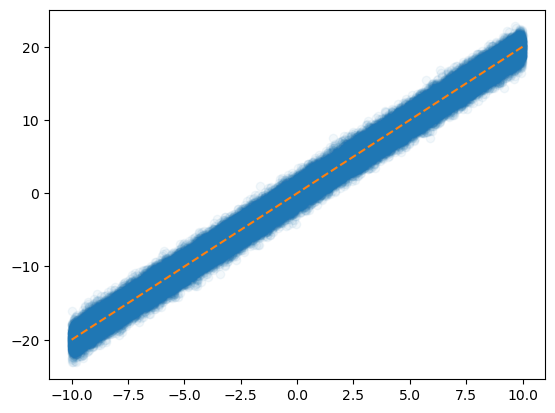

In [28]:
plt.plot(x,y,'o',alpha=0.05)
plt.plot(x,2*x,'--')

`-` 데이터의 크기가 커지는 순간 `X.to("cuda:0")`, `y.to("cuda:0")` 쓰면
난리나겠는걸?

`-` 데이터를 100개중에 1개만 꼴로만 쓰면 어떨까?

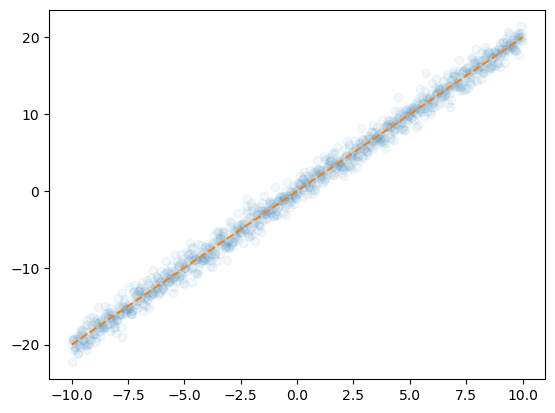

In [29]:
plt.plot(x[::100],y[::100],'o',alpha=0.05)
plt.plot(x,2*x,'--')

-   대충 이거만 가지고 적합해도 충분히 정확할것 같은데?

## B. X,y 데이터를 굳이 모두 GPU에 넘겨야 하는가?

`-` 데이터셋을 짝홀로 나누어서 번갈아가면서 GPU에 올렸다 내렸다하면
안되나?

`-` 아래의 알고리즘을 생각해보자.

1.  데이터를 반으로 나눈다.
2.  짝수obs의 x,y 그리고 net의 모든 파라메터를 GPU에 올린다.
3.  yhat, loss, grad, update 수행
4.  짝수obs의 x,y를 GPU메모리에서 내린다. 그리고 홀수obs의 x,y를
    GPU메모리에 올린다.
5.  yhat, loss, grad, update 수행
6.  홀수obs의 x,y를 GPU메모리에서 내린다. 그리고 짝수obs의 x,y를
    GPU메모리에 올린다.
7.  반복

> 이러면 되는거아니야???? —\> 맞아요

## C. 경사하강법, 확률적경사하강법, 미니배치 경사하강법

10개의 샘플이 있다고 가정. $\{(x_i,y_i)\}_{i=1}^{10}$

`# ver1` – 모든 샘플을 이용하여 slope 계산

(epoch 1) $loss=\sum_{i=1}^{10}(y_i-w_0-w_1x_i)^2 \to slope \to update$

(epoch 2) $loss=\sum_{i=1}^{10}(y_i-w_0-w_1x_i)^2 \to slope \to update$

…

> 우리가 항상 이렇게 했죠!

`# ver2` – 하나의 샘플만을 이용하여 slope 계산

(epoch 1)

-   $loss=(y_1-w_0-w_1x_1)^2 \to slope \to update$
-   $loss=(y_2-w_0-w_1x_2)^2 \to slope \to update$
-   …
-   $loss=(y_{10}-w_0-w_1x_{10})^2 \to slope \to update$

(epoch 2)

-   $loss=(y_1-w_0-w_1x_1)^2 \to slope \to update$
-   $loss=(y_2-w_0-w_1x_2)^2 \to slope \to update$
-   …
-   $loss=(y_{10}-w_0-w_1x_{10})^2 \to slope \to update$

…

`# ver3` – $m (\leq n)$ 개의 샘플을 이용하여 slope 계산

$m=3$이라고 하자.

(epoch 1)

-   $loss=\sum_{i=1}^{3}(y_i-w_0-w_1x_i)^2 \to slope \to update$
-   $loss=\sum_{i=4}^{6}(y_i-w_0-w_1x_i)^2 \to slope \to update$
-   $loss=\sum_{i=7}^{9}(y_i-w_0-w_1x_i)^2 \to slope \to update$
-   $loss=(y_{10}-w_0-w_1x_{10})^2 \to slope \to update$

(epoch 2)

-   $loss=\sum_{i=1}^{3}(y_i-w_0-w_1x_i)^2 \to slope \to update$
-   $loss=\sum_{i=4}^{6}(y_i-w_0-w_1x_i)^2 \to slope \to update$
-   $loss=\sum_{i=7}^{9}(y_i-w_0-w_1x_i)^2 \to slope \to update$
-   $loss=(y_{10}-w_0-w_1x_{10})^2 \to slope \to update$

…

## D. 용어의 정리

**옛날**

`-` ver1: gradient descent, batch gradient descent

`-` ver2: stochastic gradient descent

`-` ver3: mini-batch gradient descent, mini-batch stochastic gradient
descent

**요즘**

`-` ver1: gradient descent

`-` ver2: stochastic gradient descent with batch size = 1

`-` **ver3: stochastic gradient descent** -
https://www.deeplearningbook.org/contents/optimization.html, 알고리즘
8-1 참고.

## E. Dataset(`ds`), DataLoader(`dl`)

> 취지는 알겠으나, C의 과정을 실제 구현하려면 진짜 힘들것 같아요..
> (입코딩과 손코딩의 차이) –\> 이걸 해결하기 위해서 파이토치에서는
> DataLoader라는 오브젝트를 준비했음!

`-` ds: 섭스크립터블함

In [30]:
x=torch.tensor(range(10)).float().reshape(-1,1)
y=torch.tensor([1.0]*5+[0.0]*5).reshape(-1,1)
torch.concat([x,y],axis=1)

In [31]:
ds=torch.utils.data.TensorDataset(x,y)
ds

In [32]:
ds.tensors 
# 생긴건 ds.tensors = (x,y) 임

In [33]:
ds[0],(x,y)[0] # (x,y) 튜플자체는 아님.. 인덱싱이 다르게 동작

> **Note**
>
> 여기서 제가 `__iter__` 가 숨겨져 있는 오브젝트일 경우만 `for`문이
> 동작한다고 설명 했는데요, `__getitem__`이 있는 경우도 동작한다고
> 합니다. **제가 잘못 알고 있었어요. 혼란을 드려 죄송합니다**.
>
> -   그래도 `dl`은 for 를 돌리기위해서 만든 오브젝트라는 설명은 맞는
>     설명입니다.
> -   `ds`역시 독특한 방식의 인덱싱을 지원하도록 한 오브젝트라는 설명도
>     맞는 설명입니다.

`-` dl: 섭스크립터블하지 않지만 이터러블함

In [34]:
dl=torch.utils.data.DataLoader(ds,batch_size=3)
#set(dir(dl)) & {'__iter__'}

In [35]:
for xi,yi in dl:
    print(f"x_batch:{xi.tolist()} \t y_batch:{yi.tolist()}")

x_batch:[[0.0], [1.0], [2.0]]    y_batch:[[1.0], [1.0], [1.0]]
x_batch:[[3.0], [4.0], [5.0]]    y_batch:[[1.0], [1.0], [0.0]]
x_batch:[[6.0], [7.0], [8.0]]    y_batch:[[0.0], [0.0], [0.0]]
x_batch:[[9.0]]      y_batch:[[0.0]]

`-` 마지막관측치는 뭔데 단독으로 업데이트하냐?? –\> shuffle True 같이
자잘한 옵션도 있음..

In [36]:
dl = torch.utils.data.DataLoader(ds,batch_size=3,shuffle=True)
for xi,yi in dl:
    print(f'x_batch={xi.tolist()} \t y_batch={yi.tolist()}')

x_batch=[[1.0], [8.0], [0.0]]    y_batch=[[1.0], [0.0], [1.0]]
x_batch=[[2.0], [7.0], [6.0]]    y_batch=[[1.0], [0.0], [0.0]]
x_batch=[[5.0], [3.0], [9.0]]    y_batch=[[0.0], [1.0], [0.0]]
x_batch=[[4.0]]      y_batch=[[1.0]]

## F. ds, dl을 이용한 MNIST 구현

`-` 목표: 확률적경사하강법과 그냥 경사하강법의 성능을 “동일 반복횟수”로
비교해보자.

-   batch_size = 2048로 설정할것

`-` 그냥 경사하강법 – 미니배치 안쓰는 학습, 우리가 맨날하는 그거

In [37]:
## Step1: 데이터준비 
path = untar_data(URLs.MNIST)
X0 = torch.stack([torchvision.io.read_image(str(fname)) for fname in (path/'training/0').ls()])
X1 = torch.stack([torchvision.io.read_image(str(fname)) for fname in (path/'training/1').ls()])
X = torch.concat([X0,X1],axis=0).reshape(-1,1*28*28)/255
y = torch.tensor([0.0]*len(X0) + [1.0]*len(X1)).reshape(-1,1)
## Step2: 학습가능한 오브젝트 생성
torch.manual_seed(1)
net = torch.nn.Sequential(
    torch.nn.Linear(784,32),
    torch.nn.ReLU(),
    torch.nn.Linear(32,1),
    torch.nn.Sigmoid()
)
loss_fn = torch.nn.BCELoss()
optimizr = torch.optim.SGD(net.parameters())
## Step3: fit  
for epoc in range(700):
    # step1 
    yhat = net(X)
    # step2 
    loss = loss_fn(yhat,y)
    # step3     
    loss.backward()
    # step4 
    optimizr.step()
    optimizr.zero_grad()
## Step4: Predict 
((yhat > 0.5)*1.0 ==  y).float().mean()

`-` “확률적”경사하강법 – 미니배치 쓰는 학습

In [38]:
## Step1: 데이터준비 
path = untar_data(URLs.MNIST)
X0 = torch.stack([torchvision.io.read_image(str(fname)) for fname in (path/'training/0').ls()])
X1 = torch.stack([torchvision.io.read_image(str(fname)) for fname in (path/'training/1').ls()])
X = torch.concat([X0,X1],axis=0).reshape(-1,1*28*28)/255
y = torch.tensor([0.0]*len(X0) + [1.0]*len(X1)).reshape(-1,1)
ds = torch.utils.data.TensorDataset(X,y)
dl = torch.utils.data.DataLoader(ds,batch_size=2048)
## Step2: 학습가능한 오브젝트 생성
torch.manual_seed(1)
net = torch.nn.Sequential(
    torch.nn.Linear(784,32),
    torch.nn.ReLU(),
    torch.nn.Linear(32,1),
    torch.nn.Sigmoid()
)
loss_fn = torch.nn.BCELoss()
optimizr = torch.optim.SGD(net.parameters())
# ## Step3: fit  
for epoc in range(100):
    for xi,yi in dl:        
        # step1 
        #yihat = net(xi)
        # step2 
        loss = loss_fn(net(xi),yi)
        # step3     
        loss.backward()
        # step4 
        optimizr.step()
        optimizr.zero_grad()
# ## Step4: Predict 
((net(X) > 0.5)*1.0 ==  y).float().mean()

`-` GPU를 활용하는 “확률적”경사하강법 – 실제적으로는 이게 최종알고리즘

In [39]:
## Step1: 데이터준비 
path = untar_data(URLs.MNIST)
X0 = torch.stack([torchvision.io.read_image(str(fname)) for fname in (path/'training/0').ls()])
X1 = torch.stack([torchvision.io.read_image(str(fname)) for fname in (path/'training/1').ls()])
X = torch.concat([X0,X1],axis=0).reshape(-1,1*28*28)/255
y = torch.tensor([0.0]*len(X0) + [1.0]*len(X1)).reshape(-1,1)
ds = torch.utils.data.TensorDataset(X,y)
dl = torch.utils.data.DataLoader(ds,batch_size=2048)
## Step2: 학습가능한 오브젝트 생성
torch.manual_seed(1)
net = torch.nn.Sequential(
    torch.nn.Linear(784,32),
    torch.nn.ReLU(),
    torch.nn.Linear(32,1),
    torch.nn.Sigmoid()
).to("cuda:0")
loss_fn = torch.nn.BCELoss()
optimizr = torch.optim.SGD(net.parameters())
## Step3: fit  
for epoc in range(100):
    for xi,yi in dl:        
        # step1 
        # step2 
        loss = loss_fn(net(xi.to("cuda:0")),yi.to("cuda:0"))
        # step3     
        loss.backward()
        # step4 
        optimizr.step()
        optimizr.zero_grad()
# ## Step4: Predict
net.to("cpu")
((net(X) > 0.5)*1.0 ==  y).float().mean()

# 5. 다중클래스 분류

## A. 결론 (그냥 외우세요)

`-` 2개의 class를 구분하는 문제가 아니라 $k$개의 class를 구분해야
한다면?

***일반적인 개념***

-   손실함수: BCE loss $\to$ Cross Entropy loss
-   마지막층의 선형변환: torch.nn.Linear(?,1) $\to$ torch.nn.Linear(?,k)
-   **마지막층의 활성화: sig $\to$ softmax**

***파이토치 한정***

-   **y의형태: (n,) vector + int형 // (n,k) one-hot encoded matrix +
    float형**
-   손실함수: torch.nn.BCEWithLogitsLoss, $\to$
    torch.nn.CrossEntropyLoss
-   마지막층의 선형변환: torch.nn.Linear(?,1) $\to$ torch.nn.Linear(?,k)
-   **마지막층의 활성화: None $\to$ None (손실함수에 이미 마지막층의
    활성화가 포함)**

## B. 실습: 3개의 클래스를 구분

`-` 정리된 코드1: 통계잘하는데 파이토치 못쓰는 사람의 코드

In [40]:
## Step1: 데이터준비 
path = untar_data(URLs.MNIST)
X0 = torch.stack([torchvision.io.read_image(str(fname)) for fname in (path/'training/0').ls()])
X1 = torch.stack([torchvision.io.read_image(str(fname)) for fname in (path/'training/1').ls()])
X2 = torch.stack([torchvision.io.read_image(str(fname)) for fname in (path/'training/2').ls()])
X = torch.concat([X0,X1,X2]).reshape(-1,1*28*28)/255
y = torch.nn.functional.one_hot(torch.tensor([0]*len(X0) + [1]*len(X1)+ [2]*len(X2))).float()
## Step2: 학습가능한 오브젝트 생성
torch.manual_seed(43052)
net = torch.nn.Sequential(
    torch.nn.Linear(784,32),
    torch.nn.ReLU(),
    torch.nn.Linear(32,3),
#    torch.nn.Softmax()
)
loss_fn = torch.nn.CrossEntropyLoss()
optimizr = torch.optim.Adam(net.parameters())
## Step3: 적합 
for epoc in range(100):
    ## step1 
    netout = net(X)
    ## step2 
    loss = loss_fn(netout,y)
    ## step3 
    loss.backward()
    ## step4 
    optimizr.step()
    optimizr.zero_grad()
    
## Step4: 적합 (혹은 적합결과확인)
(netout.argmax(axis=1) == y.argmax(axis=1)).float().mean()

`-` 정리된 코드2: 파이토치를 잘하는 사람의 코드

In [41]:
## Step1: 데이터준비 
path = untar_data(URLs.MNIST)
X0 = torch.stack([torchvision.io.read_image(str(fname)) for fname in (path/'training/0').ls()])
X1 = torch.stack([torchvision.io.read_image(str(fname)) for fname in (path/'training/1').ls()])
X2 = torch.stack([torchvision.io.read_image(str(fname)) for fname in (path/'training/2').ls()])
X = torch.concat([X0,X1,X2]).reshape(-1,1*28*28)/255
#y = torch.nn.functional.one_hot(torch.tensor([0]*len(X0) + [1]*len(X1)+ [2]*len(X2))).float()
y = torch.tensor([0]*len(X0) + [1]*len(X1)+ [2]*len(X2))
## Step2: 학습가능한 오브젝트 생성
torch.manual_seed(43052)
net = torch.nn.Sequential(
    torch.nn.Linear(784,32),
    torch.nn.ReLU(),
    torch.nn.Linear(32,3),
#    torch.nn.Softmax()
)
loss_fn = torch.nn.CrossEntropyLoss()
optimizr = torch.optim.Adam(net.parameters())
## Step3: 적합 
for epoc in range(100):
    ## step1 
    netout = net(X)
    ## step2 
    loss = loss_fn(netout,y)
    ## step3 
    loss.backward()
    ## step4 
    optimizr.step()
    optimizr.zero_grad()
## Step4: 적합 (혹은 적합결과확인)    
(netout.argmax(axis=1) == y).float().mean()

-   완전같은코드임

## C. Softmax

`-` 눈치: softmax를 쓰기 직전의 숫자들은 (n,k)꼴로 되어있음. 각
observation 마다 k개의 숫자가 있는데, 그중에서 유난히 큰 하나의 숫자가
있음.

In [42]:
net(X)

In [43]:
y

`-` 수식

-   $\text{sig}(u)=\frac{e^u}{1+e^u}$
-   $\text{softmax}({\boldsymbol u})=\text{softmax}([u_1,u_2,\dots,u_k])=\big[ \frac{e^{u_1}}{e^{u_1}+\dots e^{u_k}},\dots,\frac{e^{u_k}}{e^{u_1}+\dots e^{u_k}}\big]$

`-` torch.nn.Softmax() 손계산

(예시1) – 잘못계산

In [44]:
softmax = torch.nn.Softmax(dim=0)

In [45]:
netout = torch.tensor([[-2.0,-2.0,0.0],
                        [3.14,3.14,3.14],
                        [0.0,0.0,2.0],
                        [2.0,2.0,4.0],
                        [0.0,0.0,0.0]])
netout

In [46]:
softmax(netout) 

(예시2) – 이게 맞게 계산되는 것임

In [47]:
softmax = torch.nn.Softmax(dim=1)

In [48]:
netout

In [49]:
softmax(netout)

(예시3) – 차원을 명시안하면 맞게 계산해주고 경고 줌

In [50]:
softmax = torch.nn.Softmax()

In [51]:
netout

In [52]:
softmax(netout)

/home/cgb3/anaconda3/envs/dl2024/lib/python3.11/site-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)

(예시4) – 진짜 손계산

In [53]:
netout 

In [54]:
torch.exp(netout)

In [55]:
0.1353/(0.1353 + 0.1353 + 1.0000), 0.1353/(0.1353 + 0.1353 + 1.0000), 1.0000/(0.1353 + 0.1353 + 1.0000) # 첫 obs

In [56]:
torch.exp(netout[1])/torch.exp(netout[1]).sum() # 두번째 obs 

## D. CrossEntropyLoss

`-` 수식

***`# 2개의 카테고리`***

`-` 예제1: BCELoss vs BCEWithLogisticLoss

In [57]:
y = torch.tensor([0,0,1]).reshape(-1,1).float()
netout = torch.tensor([-1, 0, 1]).reshape(-1,1).float()
y,netout

In [58]:
# 계산방법1: 공식암기
sig = torch.nn.Sigmoid()
yhat = sig(netout)
- torch.sum(torch.log(yhat)*y + torch.log(1-yhat)*(1-y))/3

In [59]:
# 계산방법2: torch.nn.BCELoss() 이용
sig = torch.nn.Sigmoid()
yhat = sig(netout)
loss_fn = torch.nn.BCELoss()
loss_fn(yhat,y)

In [60]:
# 계산방법3: torch.nn.BCEWithLogitsLoss() 이용
loss_fn = torch.nn.BCEWithLogitsLoss()
loss_fn(netout,y)

`-` 예제2: BCEWithLogisticLoss vs CrossEntropyLoss

In [61]:
torch.concat([sig(netout),1-sig(netout)],axis=1)

In [62]:
netout = torch.tensor([[3,2],[2,2],[5,6]]).float()
y = torch.tensor([[1,0],[1,0],[0,1]]).float()
y,netout #,netout[:,[1]]-netout[:,[0]]

In [63]:
softmax(netout)

In [64]:
# 계산방법1: 공식암기
-torch.sum(torch.log(softmax(netout))*y)/3

In [65]:
# 계산방법2: torch.nn.CrossEntropyLoss() 이용 + y는 one-hot으로 정리
loss_fn = torch.nn.CrossEntropyLoss()
loss_fn(netout,y)

In [66]:
# 계산방법3: torch.nn.CrossEntropyLoss() 이용 + y는 0,1 로 정리
loss_fn = torch.nn.CrossEntropyLoss()
loss_fn(netout,y)

`#`

***`# 3개의 카테고리`***

In [67]:
y = torch.tensor([2,1,2,2,0])
y_onehot = torch.nn.functional.one_hot(y)
netout = torch.tensor(
    [[-2.0000, -2.0000,  0.0000],
     [ 3.1400,  3.1400,  3.1400],
     [ 0.0000,  0.0000,  2.0000],
     [ 2.0000,  2.0000,  4.0000],
     [ 0.0000,  0.0000,  0.0000]]
)
y,y_onehot

In [68]:
## 방법1 -- 추천X
loss_fn = torch.nn.CrossEntropyLoss()
loss_fn(netout,y_onehot.float())

In [69]:
## 방법2 -- 추천O
loss_fn = torch.nn.CrossEntropyLoss()
loss_fn(netout,y)

In [71]:
## 방법3 -- 공식.. (이걸 쓰는사람은 없겠지?)
softmax = torch.nn.Softmax() 
loss_fn = torch.nn.CrossEntropyLoss()
- torch.sum(torch.log(softmax(netout))*y_onehot)/5

`#`

`-` 계산하는 공식을 아는것도 중요한데 torch.nn.CrossEntropyLoss() 에는
softmax 활성화함수가 이미 포함되어 있다는 것을 확인하는 것이 더 중요함.

`-` torch.nn.CrossEntropyLoss() 는 사실 torch.nn.CEWithSoftmaxLoss()
정도로 바꾸는 것이 더 말이 되는 것 같다.

## E. Minor Topic: 이진분류와 CrossEntropy

`-` 2개의 클래스일경우에도 CrossEntropy를 쓸 수 있지 않을까?

In [72]:
## Step1: 데이터준비 
path = untar_data(URLs.MNIST)
X0 = torch.stack([torchvision.io.read_image(str(fname)) for fname in (path/'training/0').ls()])
X1 = torch.stack([torchvision.io.read_image(str(fname)) for fname in (path/'training/1').ls()])
X = torch.concat([X0,X1]).reshape(-1,1*28*28)/255
y = torch.tensor([0]*len(X0) + [1]*len(X1))
## Step2: 학습가능한 오브젝트 생성
torch.manual_seed(43052)
net = torch.nn.Sequential(
    torch.nn.Linear(784,32),
    torch.nn.ReLU(),
    torch.nn.Linear(32,2),
    #torch.nn.Softmax()
)
loss_fn = torch.nn.CrossEntropyLoss()
optimizr = torch.optim.Adam(net.parameters())
## Step3: fit  
for epoc in range(70): 
    ## 1 
    ## 2 
    loss= loss_fn(net(X),y) 
    ## 3 
    loss.backward()
    ## 4 
    optimizr.step()
    optimizr.zero_grad() 
## Step4: Predict 
softmax = torch.nn.Softmax()
(net(X).argmax(axis=1) == y).float().mean()

`-` 이진분류문제 = “y=0 or y=1” 을 맞추는 문제 = 성공과 실패를 맞추는
문제 = 성공확률과 실패확률을 추정하는 문제

`-` softmax, sigmoid

-   softmax: (실패확률, 성공확률) 꼴로 결과가 나옴 // softmax는
    실패확률과 성공확률을 둘다 추정한다.
-   sigmoid: (성공확률) 꼴로 결과가 나옴 // sigmoid는 성공확률만
    추정한다.

`-` 그런데 “실패확률=1-성공확률” 이므로 사실상 둘은 같은걸 추정하는
셈이다. (성공확률만 추정하면 실패확률은 저절로 추정되니까)

`-` 즉 아래는 같은 표현력을 가진 모형이다.

![](https://guebin.github.io/DL2022/posts/III.%20CNN/2022-10-20-8wk-1_files/figure-html/cell-53-output-1.svg)

![](https://guebin.github.io/DL2022/posts/III.%20CNN/2022-10-20-8wk-1_files/figure-html/cell-54-output-1.svg)

`-` 둘은 같은 표현력을 가진 모형인데 학습할 파라메터는 sigmoid의 경우가
더 적다. $\to$ sigmoid를 사용하는 모형이 비용은 싸고 효과는 동일하다는
말 $\to$ 이진분류 한정해서는 softmax를 쓰지말고 sigmoid를 써야함.

-   softmax가 갑자기 너무 안좋아보이는데 sigmoid는 k개의 클래스로 확장이
    불가능한 반면 softmax는 확장이 용이하다는 장점이 있음.

## F. 정리

`-` 결론

1.  소프트맥스는 시그모이드의 확장이다.
2.  클래스의 수가 2개일 경우에는 (Sigmoid, BCEloss) 조합을 사용해야 하고
    클래스의 수가 2개보다 클 경우에는 (Softmax, CrossEntropyLoss) 를
    사용해야 한다.

`-` 그런데 사실.. 클래스의 수가 2개일 경우일때 (Softmax,
CrossEntropyLoss)를 사용해도 그렇게 큰일나는것은 아니다. (그냥 좀
비효율적인 느낌이 드는 것 뿐임. 흑백이미지를 칼라잉크로 출력하는 느낌)

***참고***

|               $y$               |            분포가정             | 마지막층의 활성화함수 |   손실함수    |
|:-------------------------------:|:-------------------------------:|:---------------------:|:-------------:|
|     3.45, 4.43, … (연속형)      |            정규분포             |  None (or Identity)   |      MSE      |
|             0 or 1              | 이항분포 with $n=1$ (=베르누이) |        Sigmoid        |      BCE      |
| \[0,0,1\], \[0,1,0\], \[1,0,0\] |       다항분포 with $n=1$       |        Softmax        | Cross Entropy |

# 6. HW

아래와 같은 자료가 있다.

In [79]:
## Step1: 데이터준비 
path = untar_data(URLs.MNIST)
X0 = torch.stack([torchvision.io.read_image(str(fname)) for fname in (path/'training/0').ls()])
X1 = torch.stack([torchvision.io.read_image(str(fname)) for fname in (path/'training/1').ls()])
X = torch.concat([X0,X1]).reshape(-1,1*28*28)/255
y = torch.tensor([0]*len(X0) + [1]*len(X1))

`(1)` 세부사항에 맞추어 위의 자료를 학습하고, accuracy를 구하라.

-   네트워크는 1개의 은닉층을 가지도록 하고, 은닉노드수는 32개로
    설정하라. 은닉층의 활성화함수는 ReLU로 설정하라.
-   손실함수를 `torch.nn.BCELoss()`로 설정하라.
-   epoch = 325로 설정하라.

`(2)` 세부사항에 맞추어 위의 자료를 학습하고, accuracy를 구하라.

-   네트워크는 1개의 은닉층을 가지도록 하고, 은닉노드수는 32개로
    설정하라. 은닉층의 활성화함수는 ReLU로 설정하라.
-   손실함수를 `torch.nn.BCEWithLogitsLoss()`로 설정하라.
-   epoch = 325로 설정하라.

`(3)` 세부사항에 맞추어 위의 자료를 학습하고, accuracy를 구하라.

-   네트워크는 1개의 은닉층을 가지도록 하고, 은닉노드수는 32개로
    설정하라. 은닉층의 활성화함수는 ReLU로 설정하라.
-   y를 one_hot 인코딩하라.
-   손실함수를 `torch.nn.CrossEntropyLoss()`로 설정하라.
-   epoch = 325로 설정하라.

**hint** 원핫인코딩을 위해 아래의 함수를 사용하라.

In [78]:
y, torch.nn.functional.one_hot(y)

`(4)` 세부사항에 맞추어 위의 자료를 학습하고, accuracy를 구하라.

-   네트워크는 1개의 은닉층을 가지도록 하고, 은닉노드수는 32개로
    설정하라. 은닉층의 활성화함수는 ReLU로 설정하라.
-   y를 (one-hot 인코딩 하지 않고) lenght-$n$인 벡터로 유지하라.
-   손실함수를 `torch.nn.CrossEntropyLoss()`로 설정하라.
-   epoch = 325로 설정하라.

`(5)` 세부사항에 맞추어 위의 자료를 학습하고, accuracy를 구하라.

-   네트워크는 1개의 은닉층을 가지도록 하고, 은닉노드수는 32개로
    설정하라. 은닉층의 활성화함수는 ReLU로 설정하라.
-   batch_size = 1024 로 설정한뒤 mini_batch를 이용한 학습을 하라.
-   y를 (one-hot 인코딩 하지 않고) lenght-$n$인 벡터로 유지하라.  
-   손실함수를 `torch.nn.CrossEntropyLoss()`로 설정하라.
-   총 iteration 수가 325가 되도록 적절하게 epoch 을 설정하라.

`(6)` 세부사항에 맞추어 위의 자료를 학습하고, accuracy를 구하라.

-   네트워크는 1개의 은닉층을 가지도록 하고, 은닉노드수는 32개로
    설정하라. 은닉층의 활성화함수는 ReLU로 설정하라.
-   batch_size = 512 로 설정한뒤 mini_batch를 이용한 학습을 하라.
-   y를 (one-hot 인코딩 하지 않고) lenght-$n$인 벡터로 유지하라.
-   손실함수를 `torch.nn.CrossEntropyLoss()`로 설정하라.
-   총 iteration 수가 325가 되도록 적절하게 epoch 을 설정하라.
-   GPU를 활용하여 학습하라.